### 1. requirements. txt 파일 완성하기

* Streamlit 서비스를 만들기 위해 필요한 Python 라이브러리를 적어놓은 코드
* Github 저장소에 내용 복사하고 생성할 것!

In [ ]:
#자신이 만든 레포지토리(저장소)에 requirements.txt 만들고 다음 내용 복붙해서 집어넣기
#내 Streamlit 페이지가 필요한 프로그래밍 라이브러리(도구)를 사전에 설치하고 활용할 수 있도록 하기 위함

streamlit
pandas
numpy
plotly
fastai2
fastbook
Pillow
gdown
opencv-python-headless
xgboost
requests

### 2. Repository(레포지토리_저장소)에 모델 학습에 활용한 CSV 데이터와 pkl 파일 업로드

* 반드시 저장소에 모델 학습에 활용할 CSV 데이터와
* pkl 파일이 최소 한 개는 올라가 있어야 함! (랜덤 포레스트는 용량이 너머 커서 피해주세요...)

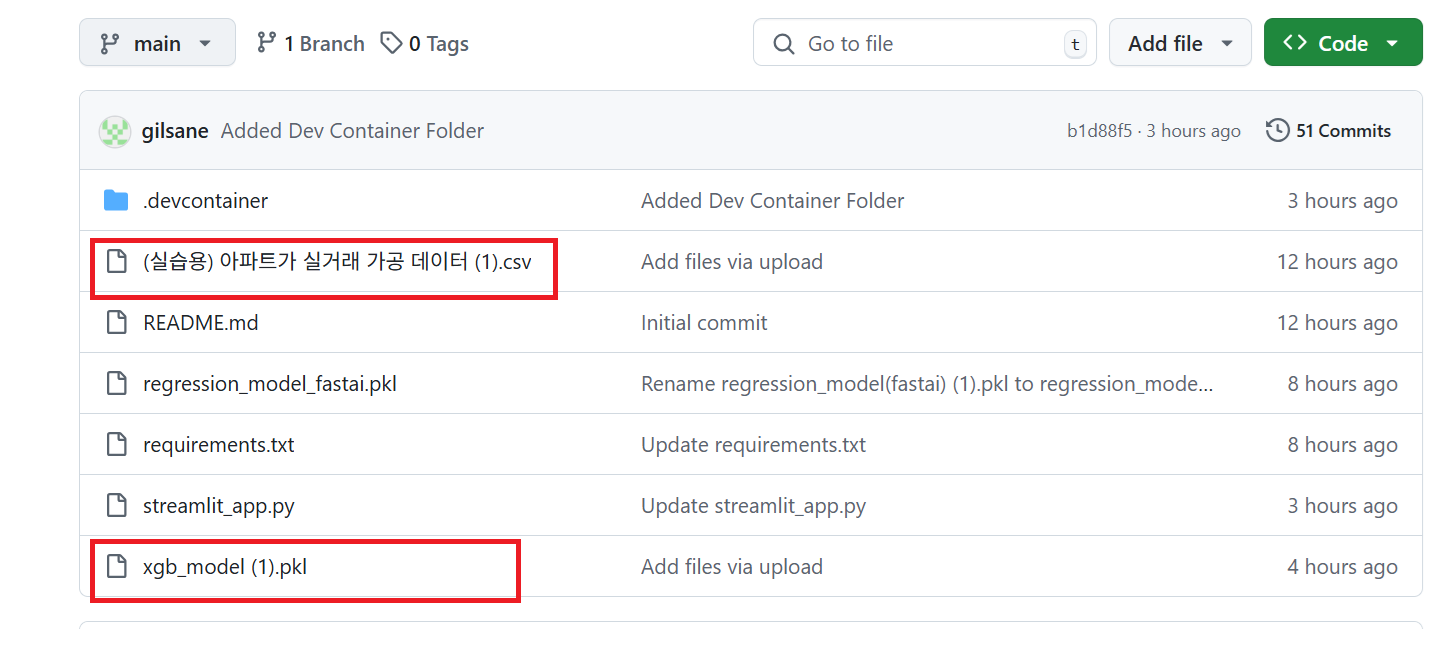

### 3. Streamlit_app.py 코드 작동 확인하기

* 아래에 있는 코드와 영상을 참조해
* 모델과 CSV 파일의 경로를 지정하고
* 프로그램이 잘 작동하는지 확인!

In [ ]:
import streamlit as st
import pickle
import requests
from fastai.learner import load_learner
import pandas as pd
import numpy as np  # numpy를 import해야 함

# Streamlit 제목
st.title("주택 가격 예측 서비스!")

# GitHub Raw 파일 URL과 모델 유형
GITHUB_RAW_URL = ""
MODEL_TYPE = ""  # "fastai", "scikit-learn Random Forest", or "XGBoost"
CSV_FILE_URL = ""

# GitHub에서 파일 다운로드 및 로드
def download_model(url, output_path="model.pkl"):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(output_path, "wb") as file:
            file.write(response.content)
        return output_path
    except Exception as e:
        st.error(f"Error downloading model: {e}")
        return None

def load_model(file_path, model_type):
    try:
        if model_type == "fastai":
            return load_learner(file_path)  # Fastai 모델 로드
        else:
            with open(file_path, "rb") as file:
                return pickle.load(file)
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None

# CSV 파일 읽기
def load_csv_with_encodings(url):
    encodings = ["utf-8", "utf-8-sig", "cp949"]
    for encoding in encodings:
        try:
            response = requests.get(url)
            response.raise_for_status()
            df = pd.read_csv(url, encoding=encoding)
            st.success(f"CSV file loaded successfully with encoding: {encoding}")
            return df
        except Exception as e:
            continue
    st.error("Failed to load CSV file with supported encodings.")
    return None



# 모델 다운로드 및 로드
downloaded_file = download_model(GITHUB_RAW_URL)
if downloaded_file:
    model = load_model(downloaded_file, MODEL_TYPE)
else:
    model = None

if model is not None:
    st.success("Model loaded successfully!")

# CSV 파일 로드 및 출력
df = load_csv_with_encodings(CSV_FILE_URL)
if df is not None:
    st.write("### Data Preview")
    st.dataframe(df.head())

    # 사용자 입력 레이아웃 생성
    st.write("### User Input Form")
    col1, col2 = st.columns(2)

    if isinstance(model, dict):  # 모델이 딕셔너리인지 확인
        with col1:
            st.write("**Categorical Features**")
            cat_inputs = {}
            if "cat_names" in model and model["cat_names"]:
                for cat in model["cat_names"]:
                    if cat in df.columns:
                        cat_inputs[cat] = st.selectbox(f"{cat}", options=df[cat].unique())

        with col2:
            st.write("**Continuous Features**")
            cont_inputs = {}
            if "cont_names" in model and model["cont_names"]:
                for cont in model["cont_names"]:
                    if cont in df.columns:
                        cont_inputs[cont] = st.text_input(f"{cont}", value="", placeholder="Enter a number")

    else:
        st.error("The loaded model is not in the expected dictionary format.")



# 예측 버튼 및 결과 출력
prediction = 0
if st.button("Predict"):
    try:
        # 입력 데이터 준비
        input_data = []

        # 범주형 데이터 인코딩
        for cat in model["cat_names"]:  # 메타데이터에서 cat_names 가져오기
            if cat in cat_inputs:
                category = cat_inputs[cat]
                encoded_value = model["categorify_maps"][cat].o2i[category]  # 인코딩된 값 가져오기
                input_data.append(encoded_value)

        # 연속형 데이터 정규화
        for cont in model["cont_names"]:  # 메타데이터에서 cont_names 가져오기
            if cont in cont_inputs:
                raw_value = float(cont_inputs[cont])  # 입력값을 float으로 변환
                mean = model["normalize"][cont]["mean"]
                std = model["normalize"][cont]["std"]
                normalized_value = (raw_value - mean) / std  # 정규화 수행
                input_data.append(normalized_value)

        # 예측 수행
        columns = model["cat_names"] + model["cont_names"]  # 열 이름 설정
        input_df = pd.DataFrame([input_data], columns=columns)  # DataFrame으로 변환
        prediction = model["model"].predict(input_df)[0]

        # 결과 출력
        y_name = model.get("y_names", ["Prediction"])[0]
        st.success(f"{y_name}: {prediction}")
    except Exception as e:
        st.error(f"Error during prediction: {e}")

# 예측 결과에 따라 콘텐츠 표시
if prediction!=0:
    if prediction <= 60000:
        st.write("### Prediction Result: Low Price Segment")
        col1, col2, col3 = st.columns(3)

        with col1:
            st.image("https://via.placeholder.com/300", caption="Low Segment Image 1")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")  # YouTube 썸네일
            st.text("Description for Low Segment 1")

        with col2:
            st.image("https://via.placeholder.com/300", caption="Low Segment Image 2")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
            st.text("Description for Low Segment 2")

        with col3:
            st.image("https://via.placeholder.com/300", caption="Low Segment Image 3")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
            st.text("Description for Low Segment 3")

    elif 60000 < prediction <= 120000:
        st.write("### Prediction Result: Medium Price Segment")
        col1, col2, col3 = st.columns(3)

        with col1:
            st.image("https://via.placeholder.com/300", caption="Medium Segment Image 1")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
            st.text("Description for Medium Segment 1")

        with col2:
            st.image("https://via.placeholder.com/300", caption="Medium Segment Image 2")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
            st.text("Description for Medium Segment 2")

        with col3:
            st.image("https://via.placeholder.com/300", caption="Medium Segment Image 3")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
            st.text("Description for Medium Segment 3")

    else:
        st.write("### Prediction Result: High Price Segment")
        col1, col2, col3 = st.columns(3)

        with col1:
            st.image("https://via.placeholder.com/300", caption="High Segment Image 1")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
            st.text("Description for High Segment 1")

        with col2:
            st.image("https://via.placeholder.com/300", caption="High Segment Image 2")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
            st.text("Description for High Segment 2")

        with col3:
            st.image("https://via.placeholder.com/300", caption="High Segment Image 3")
            st.video("https://www.youtube.com/watch?v=dQw4w9WgXcQ")
            st.text("Description for High Segment 3")